In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
BATCH_SIZE = 32
MAX_EPOCHS = 2

In [3]:
transform = transforms.Compose(
    [transforms.Grayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

train_indices = torch.arange(1000, 50000)
valid_indices = torch.arange(0, 1000)

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_dataset = torchvision.datasets.CIFAR10(root='./data', 
                               train=True, 
                               transform=transform,
                               download=True)

val_dataset = torchvision.datasets.CIFAR10(root='./data', 
                               train=True, 
                               transform=transform,
                               download=False)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          sampler=train_sampler)

val_loader = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          sampler=valid_sampler)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


In [5]:
model = Model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
def evaluate(model, loader, n_examples):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
        
    # Return mean loss, accuracy
    return running_loss / len(loader), correct / total

In [7]:
loss_history = {
        'train_loss': [],
        'val_loss': []
}

for epoch in range(MAX_EPOCHS):  # loop over the dataset multiple times
    print("Starting Epoch: {}".format(epoch+1))
    
    running_loss = 0.0
    
    for i, data in enumerate(train_loader, 0):
        model.train()
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            mean_loss = running_loss / 100
            loss_history['train_loss'].append(mean_loss)
            print('# mini-batch {}\ntrain loss: {}'.format(
                  i + 1, mean_loss))
            running_loss = 0.0
            
            # evaluate on validation dataset
            mean_loss, val_acc = evaluate(model, val_loader, len(val_dataset))
            loss_history['val_loss'].append(mean_loss)
                  
            print("validation loss: {} validation accuracy: {}\n".format(mean_loss, val_acc))

print('Finished Training')

Starting Epoch: 1
# mini-batch 100
train loss: 2.1648554742336272
validation loss: 2.014345597475767 validation accuracy: 0.239

# mini-batch 200
train loss: 2.0010694134235383
validation loss: 1.8763513416051865 validation accuracy: 0.302

# mini-batch 300
train loss: 1.8799220526218414
validation loss: 1.8470983877778053 validation accuracy: 0.335

# mini-batch 400
train loss: 1.7875312995910644
validation loss: 1.699901770800352 validation accuracy: 0.397

# mini-batch 500
train loss: 1.7125228226184845
validation loss: 1.69561180844903 validation accuracy: 0.399

# mini-batch 600
train loss: 1.6561510038375855
validation loss: 1.6040781028568745 validation accuracy: 0.407

# mini-batch 700
train loss: 1.606692898273468
validation loss: 1.5567608810961246 validation accuracy: 0.446

# mini-batch 800
train loss: 1.5816352593898773
validation loss: 1.5370026491582394 validation accuracy: 0.441

# mini-batch 900
train loss: 1.5837346041202545
validation loss: 1.5268699489533901 validat

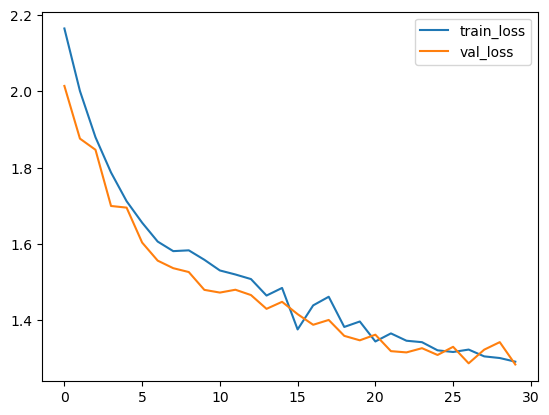

In [8]:
plt.plot(loss_history['train_loss'], label='train_loss')
plt.plot(loss_history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [9]:
_, test_acc = evaluate(model, test_loader, len(test_dataset))

In [10]:
print(test_acc)

0.5487


In [20]:
from torchinfo import summary
summary(model, (1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 30, 30]            60
├─Conv2d: 1-2                            [1, 16, 13, 13]           880
├─Linear: 1-3                            [1, 120]                  69,240
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 81,194
Trainable params: 81,194
Non-trainable params: 0
Total mult-adds (M): 0.28
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.32
Estimated Total Size (MB): 0.40